In [1]:
import xupy as xp
import matplotlib.pyplot as plt

from ekarus.e2e.devices.alpao_deformable_mirror import ALPAODM
from ekarus.e2e.utils.image_utils import get_circular_mask


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
# Option A: define a DM from the number of actuators
Npix = 128
alpao_mask = get_circular_mask((Npix,Npix),mask_radius=Npix//2)
DM468 = ALPAODM(468,alpao_mask) # defined from configuration, simulating the IFFs with tps module
DM241 = ALPAODM(241,alpao_mask)
# This may take a little while, especially for > 200 acts

np.float32(0.05207457)

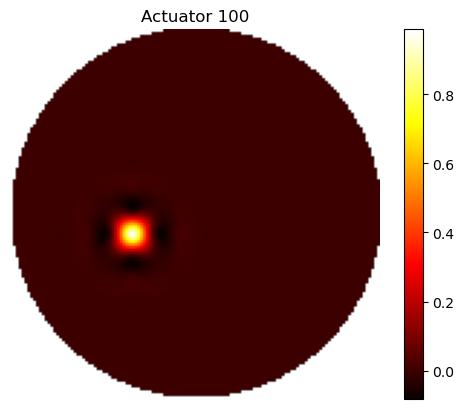

In [3]:
act_id = 100
DM241.plot_surface(surf2plot=DM241.IFF[:,act_id],title = f'Actuator {act_id}')

Unobscured actuators: 416/468
[148 149 150 151 171 172 173 174 175 176 194 195 196 197 198 199 200 201
 218 219 220 221 222 223 224 225 242 243 244 245 246 247 248 249 266 267
 268 269 270 271 272 273 291 292 293 294 295 296 316 317 318 319]


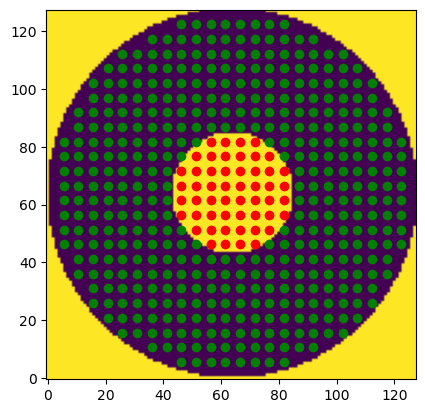

In [4]:
import ekarus.e2e.utils.deformable_mirror_utilities as dmutils

anular_mask = xp.logical_or(get_circular_mask((Npix,Npix),mask_radius=Npix//2),~get_circular_mask((Npix,Npix),mask_radius=Npix//6))

ma_DM468 = ALPAODM(468,pupil_mask=anular_mask)

is_slave = xp.ones(ma_DM468.Nacts, dtype=bool)
is_slave[ma_DM468.master_ids] = 0
slave_ids = xp.arange(ma_DM468.Nacts)
slave_ids = slave_ids[is_slave]

cmd = xp.zeros(ma_DM468.Nacts)
cmd[slave_ids] = 1e-6

pix_coords = dmutils.get_pixel_coords(anular_mask, ma_DM468.act_coords, ma_DM468.pixel_scale)

plt.figure()
plt.imshow(xp.asnumpy(anular_mask),origin='lower')
plt.scatter(xp.asnumpy(pix_coords[0,slave_ids]),xp.asnumpy(pix_coords[1,slave_ids]),c='red')
plt.scatter(xp.asnumpy(pix_coords[0,ma_DM468.master_ids]),xp.asnumpy(pix_coords[1,ma_DM468.master_ids]),c='green')

print(slave_ids)

np.float32(0.036023576)

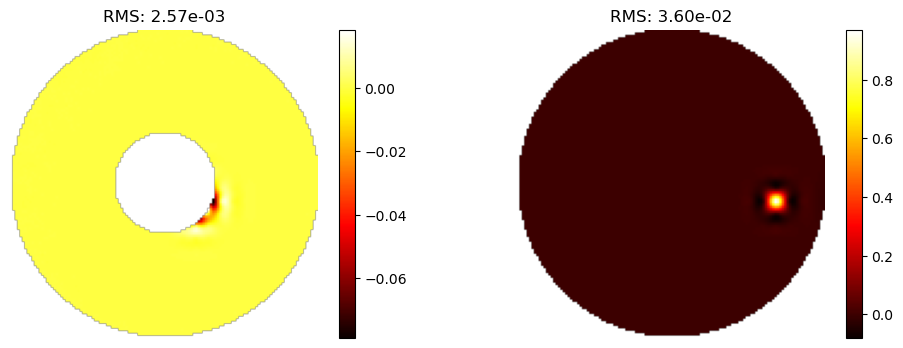

In [5]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ma_DM468.plot_surface(surf2plot=ma_DM468.IFF[:,200],plt_mask=anular_mask)

plt.subplot(1,2,2)
ma_DM468.plot_surface(surf2plot=ma_DM468.IFF[:,206])

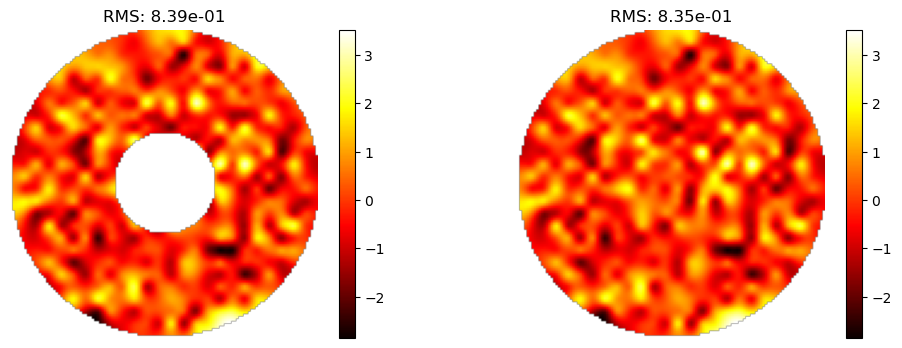

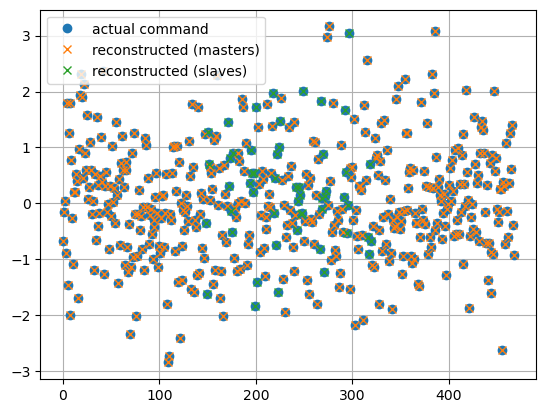

In [6]:
act_scramble = xp.random.randn(ma_DM468.Nacts)
ma_DM468.set_position(act_scramble, absolute=True)
DM468.set_position(act_scramble, absolute=True)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ma_DM468.plot_surface(plt_mask = anular_mask)
plt.subplot(1,2,2)
DM468.plot_surface()

rec_cmd = DM468.R @ DM468.surface
ma_rec_cmd = ma_DM468.R @ ma_DM468.surface

plt.figure()
plt.plot(xp.asnumpy(act_scramble),'o',label='actual command')
plt.plot(xp.asnumpy(ma_DM468.master_ids), xp.asnumpy(ma_rec_cmd[ma_DM468.master_ids]),'x',label='reconstructed (masters)')
plt.plot(xp.asnumpy(slave_ids), xp.asnumpy(ma_rec_cmd[slave_ids]),'x',label='reconstructed (slaves)')
plt.grid()
plt.legend()

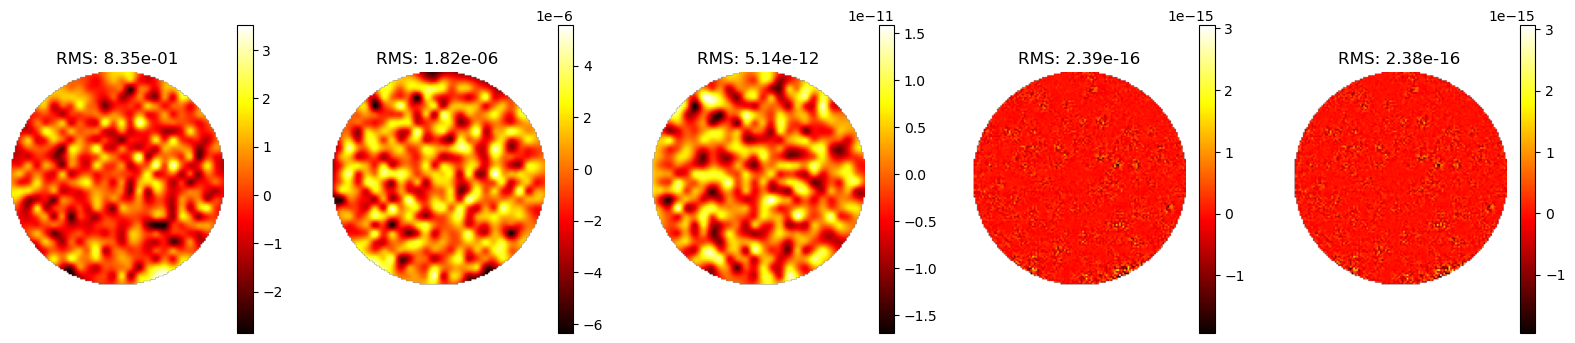

In [7]:


N = 5
plt.figure(figsize=(4*N,4))
plt.subplot(1,N,1)
dm_surface = DM468.IFF @ act_scramble
res_surf = dm_surface.copy()
DM468.plot_surface(dm_surface)
for i in range(1,N):
    new_cmd = DM468.R @ res_surf
    res_surf -= DM468.IFF @ new_cmd
    plt.subplot(1,N,i+1)
    DM468.plot_surface(res_surf)

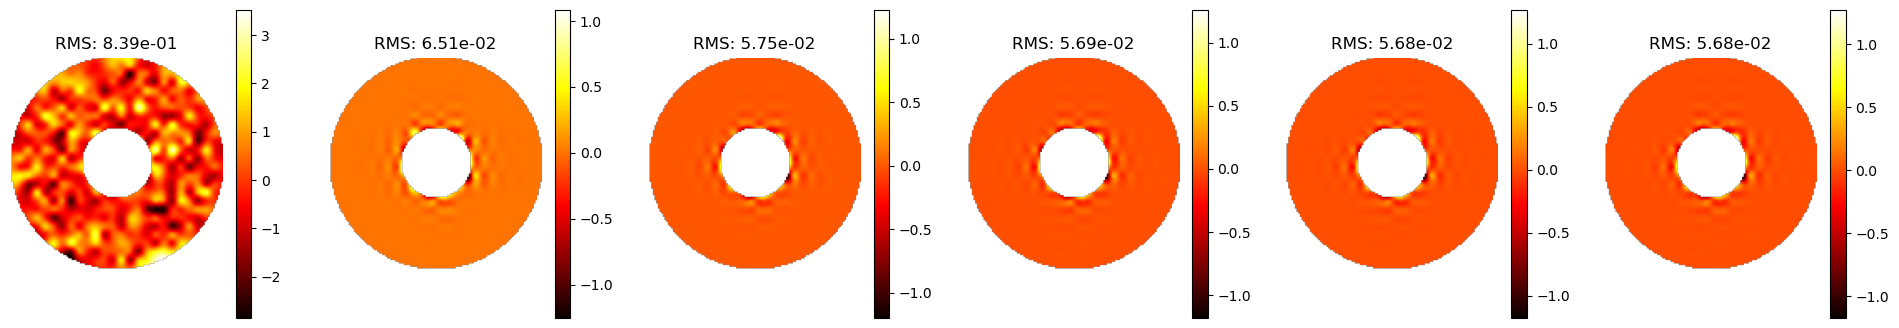

In [22]:
N = 6
plt.figure(figsize=(4*N,4))
plt.subplot(1,N,1)
dm_surf = DM468.IFF @ act_scramble
res_surf = dm_surf.copy()
ma_DM468.plot_surface(dm_surf, plt_mask=anular_mask)
for i in range(1,N):
    new_cmd = ma_DM468.R[:,ma_DM468.visible_pix_ids] @ res_surf[ma_DM468.visible_pix_ids]
    slaved_cmd = ma_DM468.slaving @ new_cmd[ma_DM468.master_ids]
    rec_surf = ma_DM468.IFF @ slaved_cmd
    res_surf -= rec_surf
    ma_DM468.set_position(new_cmd)
    plt.subplot(1,N,i+1)
    ma_DM468.plot_surface(res_surf,plt_mask=anular_mask)

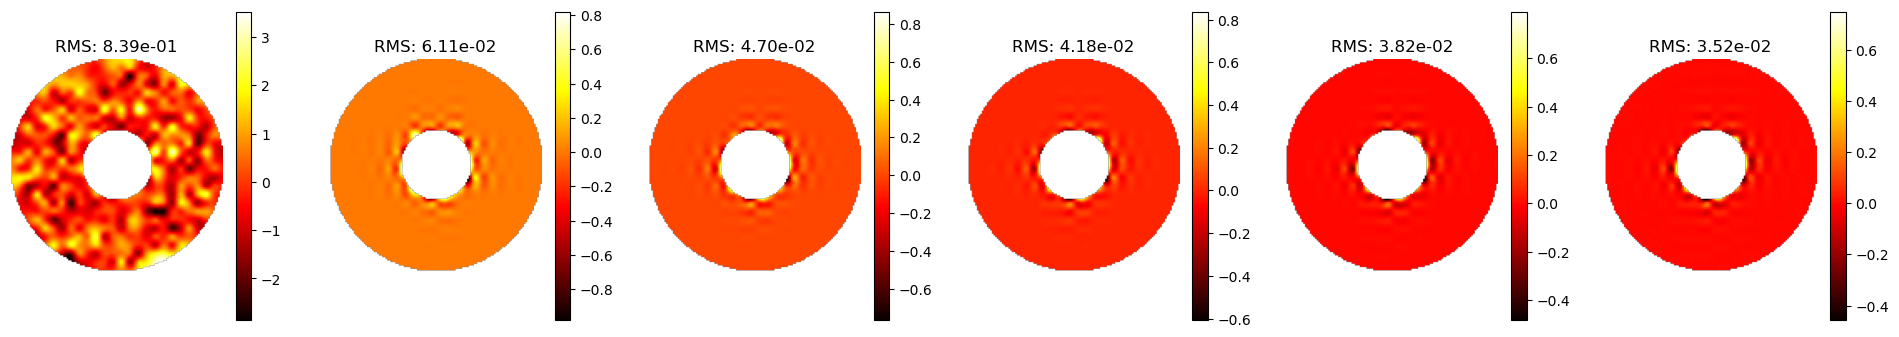

In [21]:
N = 6
plt.figure(figsize=(4*N,4))
plt.subplot(1,N,1)
dm_surf = DM468.IFF @ act_scramble
res_surf = dm_surf.copy()
ma_DM468.plot_surface(dm_surf, plt_mask=anular_mask)
for i in range(1,N):
    new_cmd = ma_DM468.R[:,ma_DM468.visible_pix_ids] @ res_surf[ma_DM468.visible_pix_ids]
    rec_surf = ma_DM468.IFF @ new_cmd
    res_surf -= rec_surf
    ma_DM468.set_position(new_cmd)
    plt.subplot(1,N,i+1)
    ma_DM468.plot_surface(res_surf,plt_mask=anular_mask)

[-13.82031263   0.02451489   0.04029838]


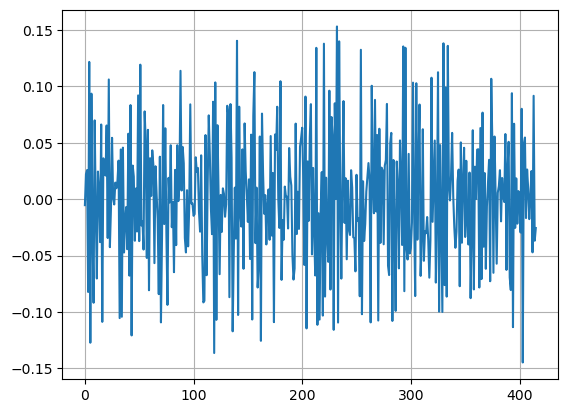

In [9]:
# TPS slaving implementation
act_coords = dmutils.get_pixel_coords(ma_DM468.mask, ma_DM468.act_coords, ma_DM468.pixel_scale)
master_coords = act_coords[:,ma_DM468.master_ids]
nMasters = len(ma_DM468.master_ids)
P = xp.ones([nMasters,3])
P[:,1] = master_coords[0,:].T
P[:,2] = master_coords[1,:].T
dist = lambda xy_i, xy_j: xp.sqrt((xy_i[0]-xy_j[0])**2+(xy_i[1]-xy_j[1])**2)
fun = lambda r: r**2*xp.log(r)
K = xp.zeros([nMasters,nMasters])
for i in range(nMasters):
    for j in range(nMasters):
        if i != j:
            K[i,j] = fun(dist(master_coords[:,i],master_coords[:,j]))

A = xp.zeros([nMasters+3,nMasters+3])
A[:nMasters,:nMasters] = K
A[nMasters:,:nMasters] = P.T
A[:nMasters,nMasters:] = P

x = xp.zeros(nMasters+3)
x[:nMasters] = ma_rec_cmd[ma_DM468.master_ids]

b = xp.linalg.inv(A) @ x

w = b[:nMasters]
alphas = b[nMasters:]

plt.figure()
plt.plot(xp.asnumpy(w))
plt.grid()

print(alphas)

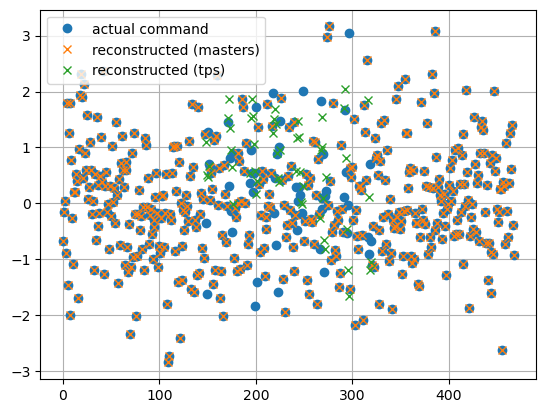

In [16]:
# Perform the fit
slave_coords = act_coords[:,slave_ids]
slave_cmd = xp.zeros(len(slave_ids))
for k in range(len(slave_ids)):
    xk,yk = slave_coords[:,k]
    slave_cmd[k] = alphas[1]*xk + alphas[2]*yk + xp.dot(w,fun(dist(slave_coords[:,k],master_coords))) + alphas[0]


tps_rec_cmd = ma_rec_cmd.copy()
tps_rec_cmd[slave_ids] = slave_cmd

plt.figure()
plt.plot(xp.asnumpy(act_scramble),'o',label='actual command')
plt.plot(xp.asnumpy(ma_DM468.master_ids), xp.asnumpy(tps_rec_cmd[ma_DM468.master_ids]),'x',label='reconstructed (masters)')
plt.plot(xp.asnumpy(slave_ids), xp.asnumpy(slave_cmd),'x',label='reconstructed (tps)')
plt.grid()
plt.legend()


np.float32(1.8244554e-06)

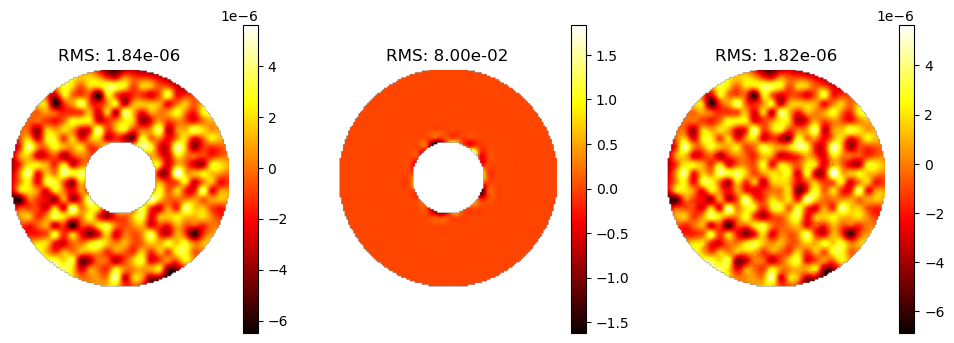

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
ma_DM468.plot_surface(ma_DM468.IFF @ (act_scramble-ma_rec_cmd),plt_mask=anular_mask)
plt.subplot(1,3,2)
ma_DM468.plot_surface(ma_DM468.IFF @ (act_scramble-tps_rec_cmd),plt_mask=anular_mask)
plt.subplot(1,3,3)
DM468.plot_surface(DM468.IFF @ act_scramble - DM468.IFF @ rec_cmd)

In [12]:
# # TPS slaving implementation
# # from arte.math.toccd import toccd
# mask_coords = dmutils.getMaskPixelCoords(ma_DM468.mask)
# mask_coords[0] -= xp.min(mask_coords[0])
# mask_coords[1] -= xp.min(mask_coords[1])
# mask_coords *= ma_DM468.pixel_scale
# master_coords = mask_coords[:,ma_DM468.visible_pix_ids]
# nMasters = len(master_coords[0])
# P = xp.ones([nMasters,3])
# P[:,1] = master_coords[0,:].T
# P[:,2] = master_coords[1,:].T
# dist = lambda xy_i, xy_j: xp.sqrt((xy_i[0]-xy_j[0])**2+(xy_i[1]-xy_j[1])**2)
# fun = lambda r: r**2*xp.log(r)
# K = xp.zeros([nMasters,nMasters])
# for i in range(nMasters):
#     for j in range(nMasters):
#         if i != j:
#             K[i,j] = fun(dist(master_coords[:,i],master_coords[:,j]))

# A = xp.zeros([nMasters+3,nMasters+3])
# A[:nMasters,:nMasters] = K
# A[nMasters:,:nMasters] = P.T
# A[:nMasters,nMasters:] = P

# x = xp.zeros(nMasters+3)
# x[:nMasters] = ma_rec_cmd[ma_DM468.visible_pix_ids]

# U,D,V = xp.linalg.svd(A,full_matrices=False)
# pinvA = (V.T * 1/D) @ U.T

In [13]:
# b = pinvA @ x

# w = b[:nMasters]
# alphas = b[nMasters:]

# # Perform the fit
# slave_coords = act_coords[:,slave_ids]
# slave_cmd = xp.zeros(len(slave_ids))
# for k in range(len(slave_ids)):
#     xk,yk = slave_coords[:,k]
#     slave_cmd[k] = alphas[0] + alphas[1]*xk + alphas[2]*yk + xp.dot(w,fun(dist(slave_coords[:,k],master_coords)))


# tps_rec_cmd = ma_rec_cmd.copy()
# tps_rec_cmd[slave_ids] = slave_cmd

# plt.figure()
# plt.plot(xp.asnumpy(act_scramble),'o',label='actual command')
# plt.plot(xp.asnumpy(ma_DM468.master_ids), xp.asnumpy(ma_rec_cmd[ma_DM468.master_ids]),'x',label='reconstructed (masters)')
# plt.plot(xp.asnumpy(slave_ids), xp.asnumpy(slave_cmd),'x',label='reconstructed (tps)')
# plt.grid()
# plt.legend()

In [14]:
# plt.figure(figsize=(12,4))
# plt.subplot(1,3,1)
# ma_DM468.plot_surface(ma_DM468.IFF @ (act_scramble-ma_rec_cmd))#plt_mask=anular_mask)
# plt.subplot(1,3,2)
# ma_DM468.plot_surface(ma_DM468.IFF @ (act_scramble-tps_rec_cmd))
# plt.subplot(1,3,3)
# DM468.plot_surface(DM468.IFF @ (act_scramble-rec_cmd))

In [15]:
# Option B: define a DM from real data

# IMPORTANT: make sure you have downloaded the correct data
# from the wiki and uploaded it into ekarus/ekarus/e2e/alpao_dms/
# you can download the data from the wiki:
# http://aowiki.arcetri.inaf.it/pub/ADOPT/AlpaoDm820/20250217_160029.zip?_t=1749657304

tn = '20250217_160029' # Make sure you have downloaded
DM820 = ALPAODM(tn) # defined from data measurements

TypeError: Unsupported type <class 'NoneType'>

In [ ]:
tn = '20250227_145613' # Make sure you have downloaded
DM468 = ALPAODM(tn) # defined from data measurements

TypeError: _XupyMaskedArray.sum() takes 1 positional argument but 5 were given

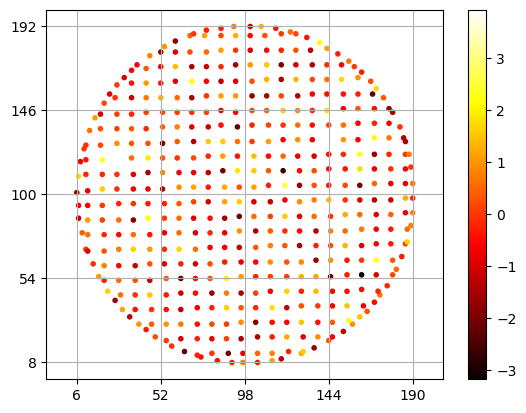

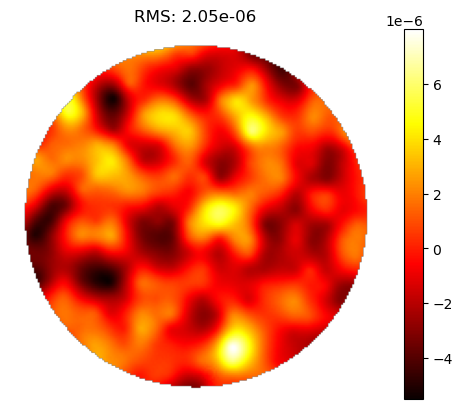

In [ ]:
new_cmd = xp.random.randn(DM468.Nacts)*1e-6
DM468.set_position(new_cmd)
plt.figure(), DM468.plot_position()
plt.figure(), DM468.plot_surface()
plt.colorbar()

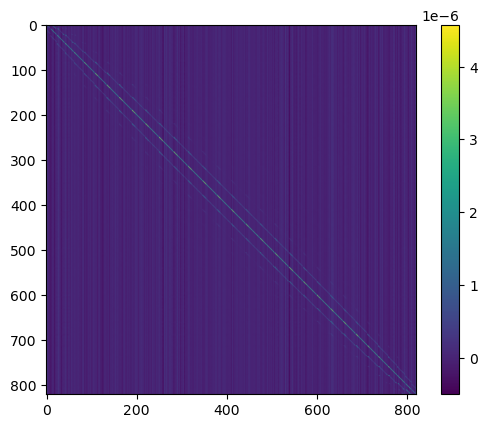

In [ ]:
plt.figure()
plt.imshow(DM820.K)
plt.colorbar()

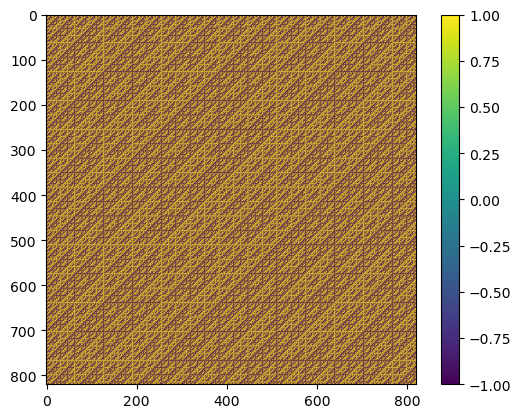

In [ ]:
plt.figure()
plt.imshow(DM820.CMat)
plt.colorbar()

np.float64(1.0412570153671917e-07)

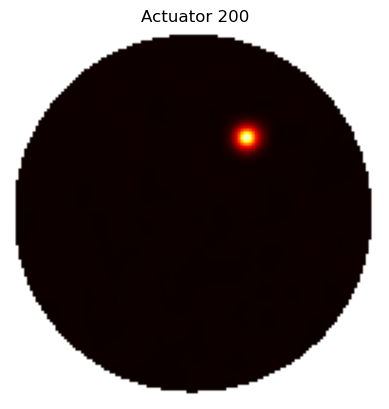

In [ ]:
# Show IFFs
act_id = 200
DM820.plot_surface(surf2plot=DM820.IFF[:,act_id],title = f'Actuator {act_id}')

np.float64(0.03743883989395621)

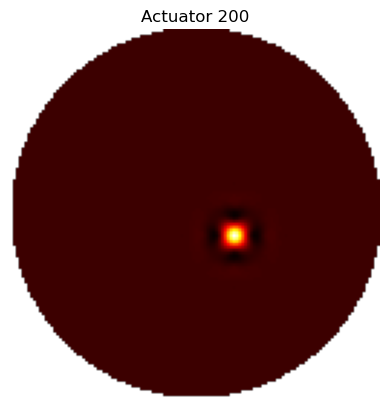

In [ ]:
# Show IFFs
act_id = 200
DM468.plot_surface(surf2plot=DM468.IFF[:,act_id],title = f'Actuator {act_id}')

In [ ]:
CmdMat = DM820.CMat
CmdMat.shape

(820, 820)

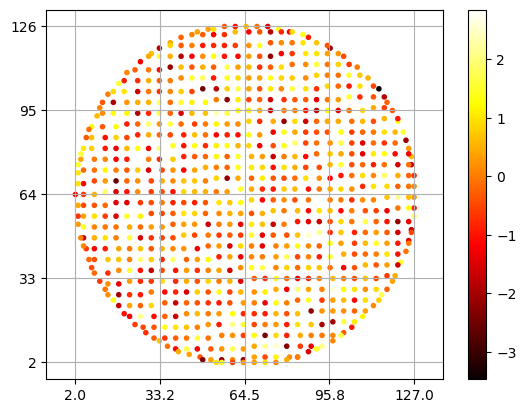

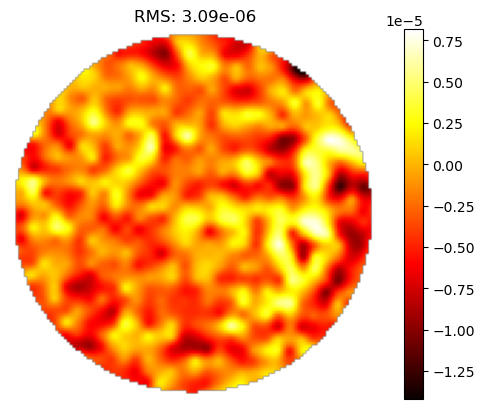

In [ ]:
# Apply a random command
new_cmd = xp.random.randn(DM820.Nacts)
DM820.set_position(new_cmd)
plt.figure(), DM820.plot_position()
plt.figure(), DM820.plot_surface()
plt.colorbar()

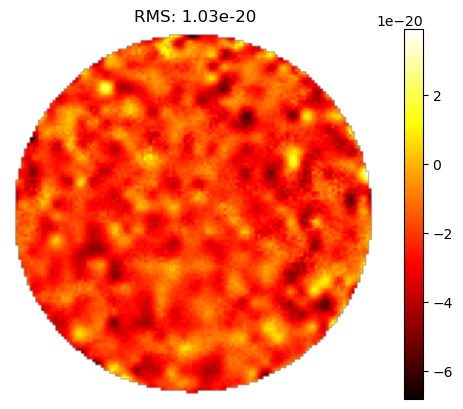

In [ ]:
# Apply flat
start_surface = DM820.surface
flat_cmd = DM820.R @ start_surface
DM820.set_position(-flat_cmd)

DM820.plot_surface()
plt.colorbar()

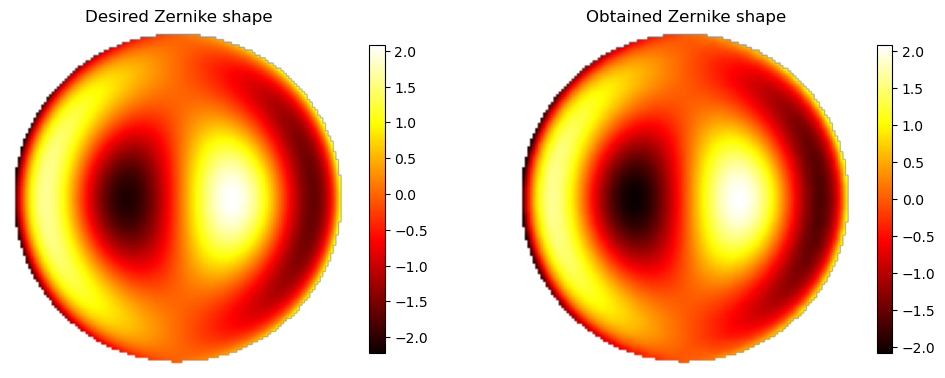

In [ ]:
# Apply a Zernike mode
from arte.types.mask import CircularMask
from ekarus.e2e.utils.zernike_coefficients import create_field_from_zernike_coefficients

mask = CircularMask(xp.shape(DM820.mask), maskRadius=xp.min(xp.shape(DM820.mask))//2)

noll = 16
zern_amp = 1
input_field = create_field_from_zernike_coefficients(mask, noll, zern_amp)

zern = xp.angle(input_field)

intersection_mask = xp.logical_or(mask.mask(), DM820.mask)
zern_shape = zern.data[~intersection_mask]

zern_cmd = DM820.R @ zern_shape
DM820.set_position(zern_cmd, absolute = True)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
DM820.plot_surface(surf2plot = zern_shape, plt_mask = mask.mask(), title='Desired Zernike shape')
plt.colorbar(shrink=0.5)

plt.subplot(1,2,2)
DM820.plot_surface(title='Obtained Zernike shape')
plt.colorbar(shrink=0.5)

In [ ]:

def get_circular_mask_from_dm_mask(dm, oversampling:int):

    nx=xp.max(dm.mask.shape)
    padded_mask = xp.pad(dm.mask, pad_width=(oversampling-1)*nx//2, constant_values=1)

    nx,ny=padded_mask.shape
    x = xp.arange(nx)
    y = xp.arange(ny)
    X, Y = xp.meshgrid(x, y)

    Npix = xp.sum(1-dm.mask)
    cx = int(xp.round(xp.sum(X[~padded_mask])/Npix))
    cy = int(xp.round(xp.sum(Y[~padded_mask])/Npix))

    R = xp.sqrt((X-cx)**2+(Y-cy)**2)
    radius = xp.max(R[~padded_mask])

    mask = CircularMask(padded_mask.shape, maskRadius=radius, maskCenter = (cx,cy))
    mask._mask = padded_mask

    return mask

mask820 = get_circular_mask_from_dm_mask(DM820, oversampling=4)
mask468 = get_circular_mask_from_dm_mask(DM468, oversampling=4)

# plt.figure()
# plt.imshow(mask.mask())

# plt.figure()
# plt.imshow(padded_mask)

# plt.figure()
# plt.imshow(xp.logical_xor(padded_mask,mask.mask()))

In [ ]:
# from arte.utils.zernike_generator import ZernikeGenerator

# zern_modes = 5
# zern_mask = mask820
# zg = ZernikeGenerator(zern_mask)

# for z in range(2, zern_modes + 2):
#     zern = zg.getZernike(z)

#     plt.figure()
#     plt.imshow(np.ma.masked_array(zern,zern_mask.mask()))

In [ ]:
# test KL modes generator
from ekarus.analytical.kl_modes import make_modal_base_from_ifs_fft

r0 = 5e-2
L0 = 8
diameter = 32e-3

kl_basis, m2c, singular_values = make_modal_base_from_ifs_fft(1-DM468.mask, Npix, diameter, DM468.IFF.T, r0, L0, zern_modes=0, oversampling=4, verbose = True)

Starting modal basis generation...
Input shapes: pupil_mask=(128, 128), influence_functions=(468, 12849)
Step 1: Removing modes from influence functions...
Step 2: Calculating geometric covariance matrix...
Step 3: SVD decomposition of covariance matrix...
-- IF covariance matrix SVD ---
    initial condition number is: 5.5223774909973145
Step 4: Calculating turbulence covariance matrix...
Computing turbulence covariance matrix...
Step 5: Calculating modal basis...
Final shapes: kl_basis=(467, 12849), m2c=(468, 467)


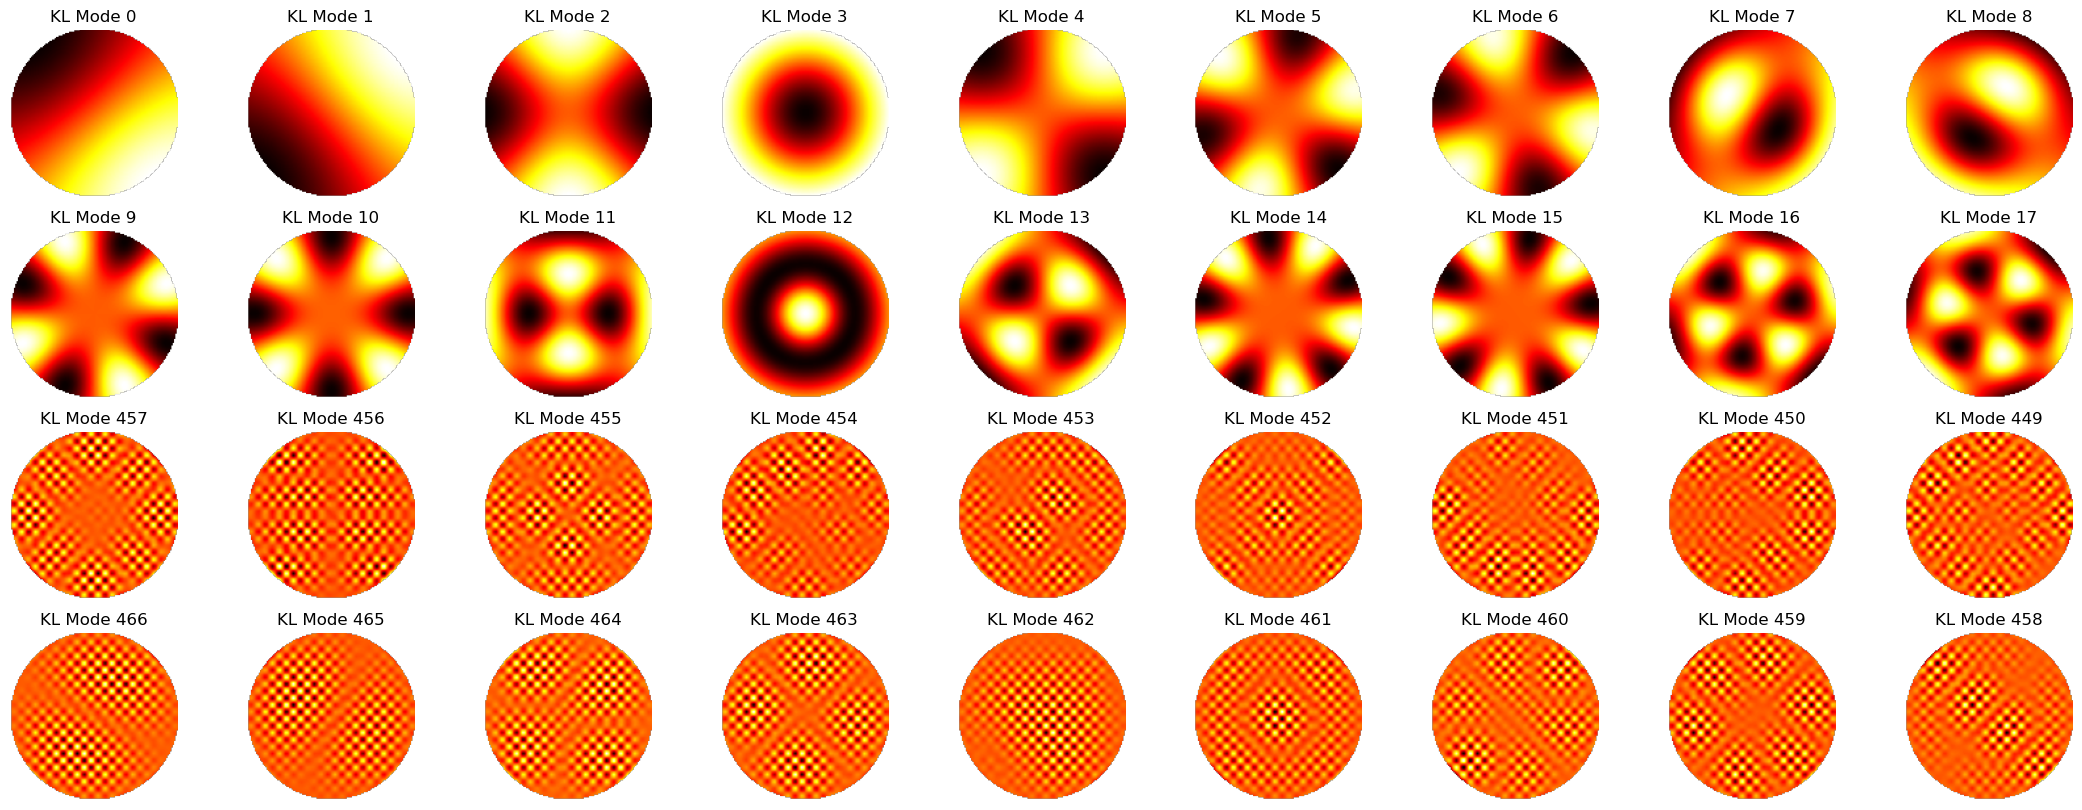

In [ ]:

N=9
plt.figure(figsize=(3*N,10))

for i in range(N):
    plt.subplot(4,N,i+1)
    DM468.plot_surface(kl_basis[i,:],title=f'KL Mode {i}')
    plt.subplot(4,N,i+1+N)
    DM468.plot_surface(kl_basis[i+N,:],title=f'KL Mode {i+N}')
    plt.subplot(4,N,i+1+N*2)
    DM468.plot_surface(kl_basis[-i-1-N,:],title=f'KL Mode {xp.shape(kl_basis)[0]-i-1-N}')
    plt.subplot(4,N,i+1+N*3)
    DM468.plot_surface(kl_basis[-i-1,:],title=f'KL Mode {xp.shape(kl_basis)[0]-i-1}')